In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload
from pprint import pprint

import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import qcodes
qc = qcodes

In [3]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin

In [4]:
from labtools.mplplots import init_nb_plotting
reload(init_nb_plotting)
from labtools.mplplots.init_nb_plotting import *

from labtools.mplplots import plots as mplplots
from labtools.mplplots import tools as mpltools

In [ ]:
# from quantum_capacitance import rf; reload(rf)
# from quantum_capacitance.rf import AlazarMeasurementExt, AWGMeasurement, AWG2DRamp

# Basic configuration

In [5]:
%run init.py

2018-02-21 09:20:53,486 : measurement : INFO : Logger set up!


Initialized IVVI-rack in 0.09s
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:514: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:526: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s


In [35]:
station.ivvi.set_dacs_zero()

In [7]:
from stationq.data.data_storage import Data, GridData
Data.export_spyview = True
GridData.export_spyview = True

In [8]:
station.key1.volt()

0.000999083318

In [9]:
station.key1.NPLC()

1.0

In [10]:
station.key2.volt()

0.00129438811

In [11]:
from stationq.qctools.instruments import create_inst
from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from visa import VisaIOError

def check_keys(ivvi):
    key1 = create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0101::MY57503556::INSTR", force_new_instance=True)
    key2 = create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR", force_new_instance=True)
    station = qc.Station(ivvi, key1, key2)
    return station

In [12]:
station = check_keys(station.ivvi)

Instrument key1 already exists.
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s
Instrument key2 already exists.


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s


# Definitions

# Experiments

## DC IV traces

In [13]:
from stationq.experiment.measurement import BaseMeasurement

class IVCurve(BaseMeasurement):
    
    start = -150.
    stop = +150
    pts = 151
    nplc = 1
    delay = 0.001
        

    def measure(self):
        try:
            self.station.key1.NPLC(self.nplc)
            self.station.key2.NPLC(self.nplc)
        except (VisaIOError, AttributeError):
            self.station = check_keys(self.station.ivvi)
            self.station.key1.NPLC(self.nplc)
            self.station.key2.NPLC(self.nplc)
        
        vals = []
        bias = np.linspace(self.start, self.stop, self.pts)

        self.station.ivvi.dac1(bias[0])
        time.sleep(1)
        
        for v in bias:
            self.station.ivvi.dac1(v)
            time.sleep(self.delay)
            try:
                amp = self.station.key1.volt()
                volt = self.station.key2.volt()
            except (VisaIOError, AttributeError):
                self.station = check_keys(self.station.ivvi)
                amp = self.station.key1.volt()
                volt = self.station.key2.volt()
            
            self.data.add(
            OrderedDict({
                'Bias' : {'value' : v * 1e-6, "unit": 'V', "independent_parameter": True},
                'Current' : {'value' : amp * 1e-7, "unit": 'A'},
                'Voltage' : {'value' : volt, 'unit' : 'V'},
                })
            )
            
            

class IMonitor(BaseMeasurement):
    
    npts = 100
    nplc = 10
    delay = 0.01
    bias = 170  
        
    def measure(self):
        try:
            self.station.key1.NPLC(self.nplc)
            self.station.key2.NPLC(self.nplc)
        except (VisaIOError, AttributeError):
            self.station = check_keys(self.station.ivvi)
            self.station.key1.NPLC(self.nplc)
            self.station.key2.NPLC(self.nplc)
        
        self.station.ivvi.dac1(self.bias)
        time.sleep(1)
        t0 = time.time()
        
        for i in range(self.npts):
            time.sleep(self.delay)
            
            try:
                amp = self.station.key1.volt()
                volt = self.station.key2.volt()
            except (VisaIOError, AttributeError):
                self.station = check_keys(self.station.ivvi)
                amp = self.station.key1.volt()
                volt = self.station.key2.volt()
            
            self.data.add(
                OrderedDict({
                    'time' : {'value' : time.time() - t0, "unit": 's', "independent_parameter": True},
                    'Current' : {'value' : amp * 1e-7, "unit": 'A'},
                    'Voltage' : {'value' : volt, 'unit' : 'V'},
                    })
            )

In [14]:
def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def find_offset(i, v, i_th=0.05, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win), fill_value='extrapolate')
    v_guess = v[np.argmin(abs(i-i_th))] 
#     print(v_guess)
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):
        print(k, v_of, i_of)
        
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = v_of + (v_pos+v_neg)/2.
        
        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
        
        return i_of, v_of
    
def fit_linslope(i, v, ilim=(0.01, 0.25), vlim=None):
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        raise ValueError('must specify limits!')
        
    i2 = i[fltr]
    v2 = v[fltr]
    p = np.polyfit(np.log(i2[i2>0]), v2[i2>0], 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope

2018-02-22 16:07:23,037 : measurement : INFO : Ready to measure, file location: d:\data\2018-02\2018-02-22\2018-02-22_IVCurve-#0192_4001pts_testing...
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


Instrument key1 already exists.
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s
Instrument key2 already exists.
Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s


2018-02-22 16:37:10,993 : measurement : INFO : Measurement finished, cleaning up...
2018-02-22 16:37:11,043 : measurement : INFO : All done!


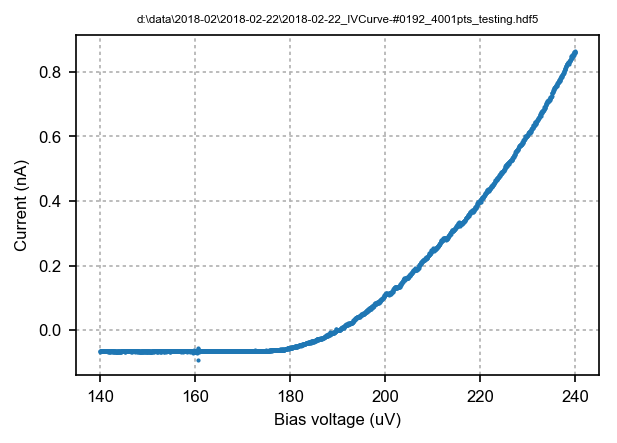

In [34]:
# T = 100
# t0 = time.time()
# delay = 5

t0 = time.time()
idx = 0
# npts = 4001

# while True:

#     for avgs in [201, 401, 801, 1601]:
    
    ### measure IV trace
m = IVCurve(station, namespace, info_string=f'{npts}_testing')
m.start = 140
m.stop = 240
m.pts = 2001
m.nplc = 10
m.delay = 0.02
m.run()

bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

i -= i[i.size//2]
bias *= 1e6
i *= 1e9

fig, ax = plt.subplots(1, 1)
ax.plot(bias, i, 'o', ms=1)
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(m.datafilepath, size='x-small')
ax.grid(dashes=[2,2])
fig.savefig(m.data_prefix + ".png", dpi=300)

#     time.sleep(60)

    ### measure current as function of time
#     if idx in [0,1]:
#         m = IMonitor(station, namespace)
#         m.npts = 20000
#         m.nplc = 1
#         m.delay = 0.1
#         m.bias = 190
#         m.run()

#         t = m.data['Current']['time [s]'].reshape(-1).copy()
#         i = m.data['Current']['Current [A]'].reshape(-1).copy()
#         v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

#         fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
#         ax.plot(t, i * 1e9, 'o', ms=2)
#         bx.plot(t, v * 1e6, 'o', ms=2)
#         ax.set_ylabel('I (nA)')
#         bx.set_ylabel('V (uV)')
#         bx.set_xlabel('time (s)')
#         ax.grid(dashes=[2,2])
#         bx.grid(dashes=[2,2])
#         fig.savefig(m.data_prefix + ".png", dpi=300)

#         time.sleep(2)
    
#     idx+=1
    
#     plt.close('all')

In [ ]:
t = m.data['Current']['time [s]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(time, i * 1e9, 'o', ms=2)
bx.plot(time, v * 1e6, 'o', ms=2)
ax.set_ylabel('I (nA)')
bx.set_ylabel('V (uV)')
bx.set_xlabel('time (s)')

In [ ]:
# bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
# i = m.data['Current']['Current [A]'].reshape(-1).copy()
# v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

# i -= i[i.size//2]
# v -= v[v.size//2]
# v *= 1e6
# i *= -1e9

# i_of, v_of = find_offset(i, v, smooth_win=50)
# i -= i_of
# v -= v_of

# fig, ax = plt.subplots(1, 1)
# ax.plot(bias * 1e3, i * 1e6, 'o', ms=1)

# fig, ax = plt.subplots(1,1)
# ax.plot(bias * 1e3, v * 1e3, 'o', ms=1)

In [ ]:
R = 15e3 + 12e3 + 2*1.7e3

bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

i -= i[i.size//2]
# v -= v[v.size//2]
# v = bias
# v -= i*R
# v -= 10e-6
v *= -1e6
i *= 1e9

i_of, v_of = find_offset(i, v, smooth_win=50)
i -= i_of
v -= v_of

fig, ax = plt.subplots(1, 1)
ax.plot(v, i, 'o', ms=1)

# kwarg = dict( 
#     ilim=None, vlim=(162, 185),
# #     vlim=None, ilim=(0.015, 0.2),
# )
# vfit, ifit, T = fit_linslope(i, v, **kwarg)
# ax.plot(vfit, ifit, label=f'T(fit) = {T*1e3:.1f} mK')
# if kwarg['ilim'] is not None:
#     ax.axhline(kwarg['ilim'][0], dashes=[1,1], lw=1, color='k')
# if kwarg['vlim'] is not None:
#     ax.axvline(kwarg['vlim'][0], dashes=[1,1], lw=1, color='k')

# ax.set_yscale('log')
# ax.set_xlim(100, 200)

ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(m.datafilepath, size='x-small')
ax.legend()
fig.savefig(m.data_prefix + "_fit.png", dpi=300)

In [ ]:
station.ivvi.set_dacs_zero()

In [ ]:
station.ivvi.dac1()

In [ ]:
### Testing: for use with sample simulator.

m = IVCurve(station, namespace)
m.start = -200
m.stop = 200
m.pts = 21
m.run()

bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

fig, ax = plt.subplots(1,1)
ax.plot(bias * 1e3, i * 1e6, 'o')

fig, ax = plt.subplots(1,1)
ax.plot(bias * 1e3, v * 1e3, 'o')

fig, ax = plt.subplots(1,1)
ax.plot(v * 1e3, i * 1e6, 'o')

R = 12e3
bias2 = bias - i*R
fig, ax = plt.subplots(1,1)
ax.plot(bias2 * 1e3, i * 1e6, 'o')

dv = v[-1] - v[0]
di = i[-1] - i[0]
print(dv/di)

dv = bias2[-1] - bias2[0]
di = i[-1] - i[0]
print(dv/di)

In [38]:
100e-6 / 22e3 * 1e7

0.045454545454545456